### Decision Tree & Random Forest

#### About the data: 
Let’s consider a Company dataset with around 10 variables and 400 records. 

The attributes are as follows: 

 Sales

 Competitor Price

 Income

 Advertising

 Population

 Price

 Shelf Location at stores

 Age

 Education

 Urban

 US

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
df = pd.read_csv("Company_Data.csv")
df.shape

(400, 11)

#### Step 1: Understand the data by doing the EDA with different visualizations to understand the patterns. Pre process the data like Handling outliers & Null values, applying one hot encoding or label encoding etc.

In [16]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [18]:
df.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


In [19]:
df.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [21]:
numeric_candidates = ['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']
for col in numeric_candidates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [22]:
df.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

In [23]:
df = df.dropna(subset=['Sales'])
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [24]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

In [25]:
num_cols = df.select_dtypes(include=['number']).columns
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

In [26]:
non_outlier_mask = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
df_clean = df[non_outlier_mask].copy()
print(f"\nRows before outlier removal: {len(df)}, after: {len(df_clean)}")


Rows before outlier removal: 400, after: 392


In [29]:
df = df_clean
sales_mean = df['Sales'].mean()
df['Sales_Category'] = np.where(df['Sales'] > sales_mean, 'High', 'Low')

In [30]:
sales_mean

np.float64(7.455586734693878)

In [31]:
df['Sales_Category'].value_counts()

Sales_Category
Low     197
High    195
Name: count, dtype: int64

In [32]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [34]:
if 'Sales_Category' in cat_cols:
    cat_cols.remove('Sales_Category')
if 'Sales' in cat_cols:
    cat_cols.remove('Sales')
cat_cols

['ShelveLoc', 'Urban', 'US']

In [35]:
multi_cat = [c for c in cat_cols if df[c].nunique() > 2]
binary_cat = [c for c in cat_cols if df[c].nunique() <= 2]

In [36]:
multi_cat

['ShelveLoc']

In [37]:
binary_cat

['Urban', 'US']

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop='first', sparse_output=False), multi_cat),
        ("labelbin", 'passthrough', binary_cat)  
    ],
    remainder='passthrough'  
)

In [41]:
le = LabelEncoder()
for c in binary_cat:
    df[c] = le.fit_transform(df[c])

In [46]:
X = df.drop(columns=['Sales', 'Sales_Category'])
y = df['Sales_Category']

In [47]:
X_trans = preprocessor.fit_transform(X)

In [48]:
oh_cols = []
if multi_cat:
    ohe = preprocessor.named_transformers_['onehot']
    try:
        oh_cols = ohe.get_feature_names_out(multi_cat).tolist()
    except:
        for c in multi_cat:
            cats = sorted(df[c].unique())
            for cat in cats[1:]:
                oh_cols.append(f"{c}_{cat}")

In [49]:
remainder_cols = binary_cat + [c for c in X.columns if c not in multi_cat + binary_cat]
feature_names = oh_cols + remainder_cols

In [50]:
X_pre = pd.DataFrame(X_trans, columns=feature_names, index=X.index)
X_pre.shape

(392, 11)

In [51]:
X_pre.head()

,ShelveLoc_Good,ShelveLoc_Medium,Urban,US,CompPrice,Income,Advertising,Population,Price,Age,Education
0,0.0,0.0,1.0,1.0,138.0,73.0,11.0,276.0,120.0,42.0,17.0
1,1.0,0.0,1.0,1.0,111.0,48.0,16.0,260.0,83.0,65.0,10.0
2,0.0,1.0,1.0,1.0,113.0,35.0,10.0,269.0,80.0,59.0,12.0
3,0.0,1.0,1.0,1.0,117.0,100.0,4.0,466.0,97.0,55.0,14.0
4,0.0,0.0,1.0,0.0,141.0,64.0,3.0,340.0,128.0,38.0,13.0


#### Step 2: Split the data to train and test.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((313, 11), (79, 11), (313,), (79,))

#### Step 3: Build a basic model using the Decision tree.

In [94]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### Step 4: Do hyperparameter tuning on the model.

In [93]:
y_pred_dt = dt.predict(X_test)
y_pred_dt

array(['High', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low', 'Low',
       'Low', 'High', 'High', 'Low', 'High', 'High', 'Low', 'Low', 'High',
       'Low', 'High', 'Low', 'High', 'Low', 'Low', 'Low', 'Low', 'High',
       'Low', 'High', 'High', 'Low', 'Low', 'Low', 'Low', 'High', 'Low',
       'Low', 'High', 'Low', 'High', 'Low', 'High', 'Low', 'High', 'Low',
       'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'High',
       'High', 'Low', 'Low', 'Low', 'High', 'High', 'Low', 'High', 'Low',
       'High', 'Low', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low',
       'Low', 'High', 'Low', 'High', 'High', 'High', 'High'], dtype=object)

In [92]:
dt_acc = accuracy_score(y_test, y_pred_dt)
dt_acc

0.6708860759493671

In [57]:
classification_report(y_test, y_pred_dt)

'              precision    recall  f1-score   support\n\n        High       0.69      0.62      0.65        39\n         Low       0.66      0.72      0.69        40\n\n    accuracy                           0.67        79\n   macro avg       0.67      0.67      0.67        79\nweighted avg       0.67      0.67      0.67        79\n'

In [58]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

In [59]:
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)

In [60]:
grid.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [64]:
best_dt = grid.best_estimator_
best_dt

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [63]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}

In [66]:
y_pred_bestdt = best_dt.predict(X_test)
y_pred_bestdt

array(['High', 'Low', 'High', 'High', 'Low', 'High', 'Low', 'Low', 'High',
       'Low', 'High', 'High', 'Low', 'High', 'High', 'Low', 'High',
       'High', 'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'High', 'Low',
       'High', 'Low', 'Low', 'High', 'Low', 'Low', 'Low', 'Low', 'High',
       'Low', 'Low', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low',
       'Low', 'High', 'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'High',
       'High', 'High', 'Low', 'High', 'High', 'High', 'High', 'Low',
       'High', 'Low', 'High', 'Low', 'High', 'High', 'Low', 'Low', 'High',
       'Low', 'Low', 'Low', 'High', 'High', 'High', 'High', 'Low', 'High'],
      dtype=object)

In [67]:
bestdt_acc = accuracy_score(y_test, y_pred_bestdt)
bestdt_acc

0.7341772151898734

In [68]:
classification_report(y_test, y_pred_bestdt)

'              precision    recall  f1-score   support\n\n        High       0.74      0.72      0.73        39\n         Low       0.73      0.75      0.74        40\n\n    accuracy                           0.73        79\n   macro avg       0.73      0.73      0.73        79\nweighted avg       0.73      0.73      0.73        79\n'

#### Step 5: Apply Random Forest, Bagging and boosting methods.

In [70]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
y_pred_rf = rf.predict(X_test)
y_pred_rf

array(['High', 'High', 'High', 'High', 'Low', 'High', 'Low', 'Low', 'Low',
       'Low', 'High', 'High', 'High', 'Low', 'High', 'Low', 'Low', 'High',
       'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'High', 'Low', 'High',
       'High', 'Low', 'High', 'Low', 'Low', 'Low', 'Low', 'High', 'Low',
       'Low', 'High', 'Low', 'High', 'Low', 'High', 'Low', 'High', 'High',
       'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'High',
       'High', 'Low', 'High', 'High', 'Low', 'High', 'Low', 'High', 'Low',
       'High', 'High', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low',
       'High', 'High', 'Low', 'High', 'High', 'High', 'High'],
      dtype=object)

#### Ste6 6: Create a chart which shows the accuracy of all the models you have build

In [72]:
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_acc

0.810126582278481

In [73]:
fi = pd.Series(rf.feature_importances_, index=X_pre.columns).sort_values(ascending=False)
fi.head(10)

Price               0.264907
CompPrice           0.122641
Age                 0.120184
Advertising         0.104149
ShelveLoc_Good      0.099054
Income              0.098799
Population          0.085618
Education           0.052990
ShelveLoc_Medium    0.020013
US                  0.015965
dtype: float64

In [75]:
bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42, n_jobs=-1)
bag.fit(X_train, y_train)

,estimator,DecisionTreeClassifier()
,n_estimators,100
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,0


In [78]:
y_pred_bag = bag.predict(X_test)
y_pred_bag

array(['High', 'Low', 'High', 'High', 'Low', 'High', 'Low', 'Low', 'Low',
       'Low', 'High', 'High', 'High', 'Low', 'High', 'Low', 'Low', 'High',
       'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'High', 'Low', 'High',
       'High', 'High', 'High', 'Low', 'Low', 'Low', 'Low', 'High', 'Low',
       'Low', 'High', 'Low', 'Low', 'Low', 'High', 'Low', 'High', 'High',
       'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'High',
       'High', 'Low', 'High', 'High', 'Low', 'High', 'Low', 'High', 'Low',
       'High', 'High', 'High', 'Low', 'Low', 'Low', 'High', 'Low', 'Low',
       'High', 'High', 'Low', 'High', 'High', 'High', 'High'],
      dtype=object)

In [80]:
bag_acc = accuracy_score(y_test, y_pred_bag)
bag_acc

0.810126582278481

In [81]:
classification_report(y_test, y_pred_bag)

'              precision    recall  f1-score   support\n\n        High       0.82      0.79      0.81        39\n         Low       0.80      0.82      0.81        40\n\n    accuracy                           0.81        79\n   macro avg       0.81      0.81      0.81        79\nweighted avg       0.81      0.81      0.81        79\n'

In [82]:
boost = AdaBoostClassifier(n_estimators=100, random_state=42)
boost.fit(X_train, y_train)

,estimator,None
,n_estimators,100
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


In [83]:
y_pred_boost = boost.predict(X_test)
y_pred_boost

array(['High', 'Low', 'High', 'High', 'Low', 'High', 'High', 'Low', 'Low',
       'Low', 'Low', 'High', 'High', 'Low', 'High', 'Low', 'Low', 'High',
       'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'High', 'Low', 'High',
       'High', 'Low', 'High', 'Low', 'Low', 'Low', 'Low', 'High', 'Low',
       'Low', 'High', 'Low', 'Low', 'Low', 'High', 'Low', 'High', 'High',
       'High', 'Low', 'Low', 'High', 'Low', 'High', 'Low', 'High', 'High',
       'High', 'Low', 'High', 'High', 'Low', 'High', 'Low', 'High', 'Low',
       'High', 'Low', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low',
       'High', 'High', 'Low', 'High', 'High', 'High', 'High'],
      dtype=object)

In [84]:
boost_acc = accuracy_score(y_test, y_pred_boost)
boost_acc

0.8987341772151899

In [85]:
classification_report(y_test, y_pred_boost)

'              precision    recall  f1-score   support\n\n        High       0.90      0.90      0.90        39\n         Low       0.90      0.90      0.90        40\n\n    accuracy                           0.90        79\n   macro avg       0.90      0.90      0.90        79\nweighted avg       0.90      0.90      0.90        79\n'

In [86]:
models = ['Decision Tree (base)', 'Decision Tree (tuned)', 'Random Forest', 'Bagging', 'AdaBoost']
scores = [dt_acc, bestdt_acc, rf_acc, bag_acc, boost_acc]

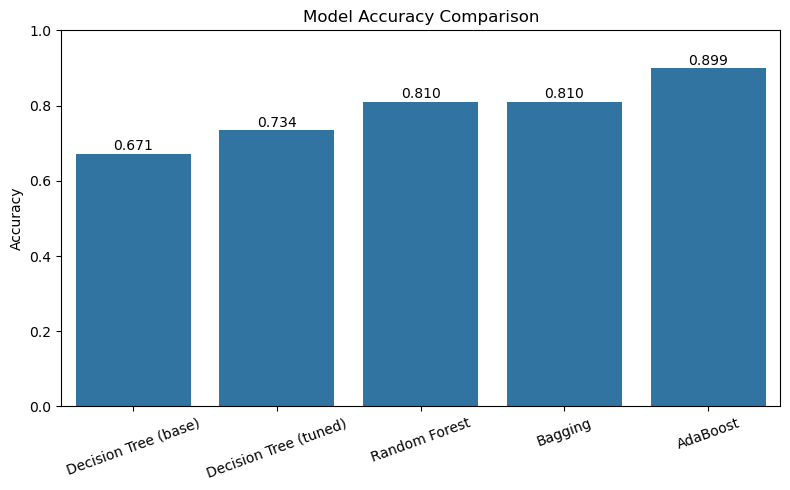

In [87]:
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=scores)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=20)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

In [88]:
best_idx = np.argmax(scores)
best_name = models[best_idx]
best_pred = [y_pred_dt, y_pred_bestdt, y_pred_rf, y_pred_bag, y_pred_boost][best_idx]

In [89]:
print(f"\nBest model: {best_name} with accuracy {scores[best_idx]:.3f}")



Best model: AdaBoost with accuracy 0.899


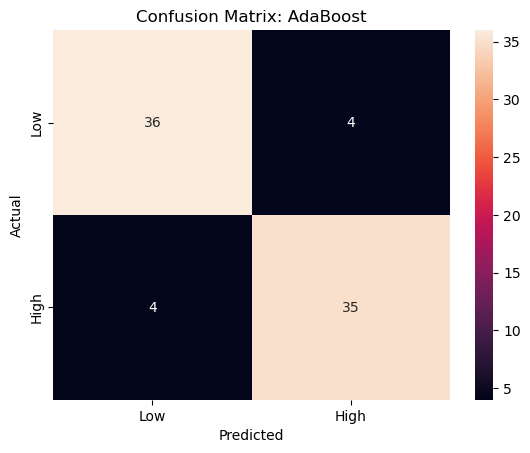

In [90]:
cm = confusion_matrix(y_test, best_pred, labels=['Low','High'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Low','High'], yticklabels=['Low','High'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'Confusion Matrix: {best_name}')
plt.show()

#### Step 7: Write conclusions.

In [91]:
print("\nConclusions:")
print("- Check feature importances above to see which factors matter most for Sales (Random Forest).")
print("- Typical top predictors in similar datasets: Price, Advertising, Income, ShelveLoc.")
print("- Ensemble methods (Random Forest / AdaBoost) usually outperform a single Decision Tree.")
print("- If class balance is skewed, consider precision/recall or using stratified sampling / class_weight.")


Conclusions:
- Check feature importances above to see which factors matter most for Sales (Random Forest).
- Typical top predictors in similar datasets: Price, Advertising, Income, ShelveLoc.
- Ensemble methods (Random Forest / AdaBoost) usually outperform a single Decision Tree.
- If class balance is skewed, consider precision/recall or using stratified sampling / class_weight.
